# Project 3: Reddit API & NLP
___

Given the title and text of a submission, predict if it was posted to the subreddit r/AskEconomics or the subreddit r/askeconomists. 
Note: These will often be abbreviated in the code as "ics" and "ists".

### Contents: 
- [Gather Data](#Get-Data)
- [EDA & Cleaning](#Exploratory-Data-Analysis-and-Cleaning)
  - [Null Values](#Null-Values)
  - [Feature Engineering](#Feature-Engineering)
  - [Preprocessing](#Preprocessing)
  - [Data Visualizations](#Data-Visualizations)
- [Data Modeling](#Model-the-Data)
  - [Model Evaluation](#Evaluate-the-Models)

# Get Data

[Return to Table of Contents](#Contents:)

In [1]:
import pandas as pd
import numpy as np
import requests
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

pd.set_option('max_columns', 85)

In [2]:
url_api_base = 'https://api.pushshift.io'
url_comment = '/reddit/search/comment'
url_submission = '/reddit/search/submission'

In [3]:
df = pd.DataFrame()

params_sub1_1 = {
    'subreddit' : 'askeconomists', 
    'before': '1d',
    'after':'300d',
    'size':500,
    'is_self' : 'true',
}
params_sub2_1 = {
    'subreddit' :  'askeconomists',
    'size': 500,
    'before': '1d',
    'after':'300d',
    'is_self' : 'true',
}
params_sub1_2 = {
    'subreddit' : 'AskEconomics',
    'size': 500,
    'before' : '300d',
    'after' : '1000d',
    'is_self' : 'true',
}
params_sub2_2 = {
    'subreddit' :  'askeconomists',
    'size': 500,
    'before' : '300d',
    'after' : '1000d',
    'is_self' : 'true',
}
params_sub1_3 = {
    'subreddit' : 'AskEconomics',
    'size': 500,
    'before' : '1000d',
    'after' : '2000d',
    'is_self' : 'true',
}
params_sub2_3 = {
    'subreddit' :  'askeconomists',
    'size': 500,
    'before' : '1000d',
    'after' : '2000d',
    'is_self' : 'true',
}
reqs = [params_sub1_1, params_sub2_1,
        params_sub1_2, params_sub2_2,
        params_sub1_3, params_sub2_3]
for req in reqs:
    res = requests.get(url_api_base+url_submission, req)
    df_req = pd.DataFrame(res.json()['data'])
    df = df.append(df_req)

df.shape

/Users/meggan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(2287, 79)

In [4]:
### Does Not Return even distribution ->
### AskEconomics     7039
### askeconomists     684

# days_range =  [i for i in range(1,2500,250)]

# dfs = []
# for day in days_range:
#     params_sub = {
#         'subreddit' : ['AskEconomics', 'askeconomists'], 
#         'before': f'{day}d',
#         'after':f'{day+250}d',
#         'size':1000,
#         'is_self' : 'true',
#     }
    
#     res = requests.get(url_api_base+url_submission, params_sub)
#     df_res = pd.DataFrame(res.json()['data'])
#     dfs.append(df_res)
    
#     time.sleep(1)
#     print(f'At {day} to {day+250} days ago')

# df = pd.concat(dfs, sort=True)
# df.shape

# Exploratory Data Analysis and Cleaning

[Return to Table of Contents](#Contents:)

In [5]:
df.head(2)

# content seems to be: selftext, title
# ...
# is_original_content, is_reddit_media_domain, is_robot_indexable, 
# is_self, is_video, link_flair_type, locked, stickied, updated_utc
# media, media_embed, media_only, secure_media, secure_media_embed
# og_description, og_title, pinned

,all_awardings,allow_live_comments,approved_at_utc,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_id,author_patreon_flair,author_premium,awarders,banned_at_utc,banned_by,brand_safe,can_mod_post,contest_mode,created_utc,domain,edited,full_link,gilded,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_embed,media_metadata,media_only,no_follow,num_comments,num_crossposts,og_description,og_title,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,removed_by_category,retrieved_on,rte_mode,score,secure_media_embed,selftext,send_replies,spoiler,steward_reports,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,updated_utc,url,view_count,whitelist_status
0,NaN,NaN,NaN,DragonGod2718,NaN,NaN,NaN,None,[],None,NaN,text,t2_2azvb7oz,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,1556123321,self.askeconomists,NaN,https://www.reddit.com/r/askeconomists/comment...,NaN,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",bgwpo3,True,False,False,False,True,True,False,,[],dark,text,False,NaN,NaN,False,True,5,0.0,NaN,NaN,False,NaN,/r/askeconomists/comments/bgwpo3/would_ubi_cau...,False,NaN,NaN,NaN,1556123323,NaN,8,NaN,[Andrew Yang](https://yang2020.com) is advocat...,True,False,NaN,False,askeconomists,t5_2w07z,885.0,public,NaN,self,NaN,NaN,"Would UBI Cause Rent Inflation, and if so is R...",NaN,1.556275e+09,https://www.reddit.com/r/askeconomists/comment...,NaN,NaN
1,[],NaN,NaN,Saurusrexed,NaN,NaN,NaN,None,[],None,NaN,text,t2_3mnnaajx,NaN,False,NaN,NaN,NaN,NaN,NaN,False,False,1556290294,self.askeconomists,NaN,https://www.reddit.com/r/askeconomists/comment...,NaN,{},bhn697,True,False,False,False,True,True,False,,[],dark,text,False,NaN,NaN,False,True,1,0.0,NaN,NaN,False,NaN,/r/askeconomists/comments/bhn697/is_it_possibl...,False,NaN,NaN,NaN,1556290298,NaN,1,NaN,Just wondering if there is an estimate. Not ju...,False,False,NaN,False,askeconomists,t5_2w07z,884.0,public,NaN,self,NaN,NaN,Is it possible to have a reasonable estimate o...,0.0,1.556377e+09,https://www.reddit.com/r/askeconomists/comment...,NaN,NaN


In [6]:
df['subreddit'].value_counts()

askeconomists    1287
AskEconomics     1000
Name: subreddit, dtype: int64

In [7]:
df[df['is_self']==False].head(2)

,all_awardings,allow_live_comments,approved_at_utc,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_id,author_patreon_flair,author_premium,awarders,banned_at_utc,banned_by,brand_safe,can_mod_post,contest_mode,created_utc,domain,edited,full_link,gilded,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_embed,media_metadata,media_only,no_follow,num_comments,num_crossposts,og_description,og_title,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,removed_by_category,retrieved_on,rte_mode,score,secure_media_embed,selftext,send_replies,spoiler,steward_reports,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,updated_utc,url,view_count,whitelist_status


In [8]:
df['is_self'].value_counts()

True    2287
Name: is_self, dtype: int64

In [9]:
len(df[df['selftext']=='[removed]'])

30

In [10]:
len(df[df['selftext']=='[deleted]'])

103

In [11]:
df[df['locked']==True]

,all_awardings,allow_live_comments,approved_at_utc,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_id,author_patreon_flair,author_premium,awarders,banned_at_utc,banned_by,brand_safe,can_mod_post,contest_mode,created_utc,domain,edited,full_link,gilded,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_embed,media_metadata,media_only,no_follow,num_comments,num_crossposts,og_description,og_title,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,removed_by_category,retrieved_on,rte_mode,score,secure_media_embed,selftext,send_replies,spoiler,steward_reports,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,updated_utc,url,view_count,whitelist_status
86,NaN,NaN,NaN,nissenissenisse,NaN,1.291836e+09,NaN,None,NaN,None,NaN,NaN,t2_4lm52,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,1495794718,self.AskEconomics,1.495797e+09,https://www.reddit.com/r/AskEconomics/comments...,0.0,NaN,6dg55q,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,{},NaN,NaN,NaN,9,NaN,NaN,NaN,False,NaN,/r/AskEconomics/comments/6dg55q/if_free_trade_...,NaN,NaN,NaN,NaN,1497181604,NaN,0,{},[removed],NaN,False,NaN,False,AskEconomics,t5_2selg,NaN,NaN,None,default,NaN,NaN,"If free trade, deregulation and low taxes for ...",NaN,NaN,https://www.reddit.com/r/AskEconomics/comments...,NaN,NaN
109,NaN,NaN,NaN,benjaminikuta,NaN,1.427771e+09,NaN,None,NaN,None,NaN,NaN,t2_mlo3i,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,1495938979,self.AskEconomics,NaN,https://www.reddit.com/r/AskEconomics/comments...,0.0,NaN,6drkcd,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,{},NaN,NaN,NaN,10,NaN,NaN,NaN,False,NaN,/r/AskEconomics/comments/6drkcd/what_portion_o...,NaN,NaN,NaN,NaN,1497187263,NaN,0,{},[removed],NaN,False,NaN,False,AskEconomics,t5_2selg,NaN,NaN,None,default,NaN,NaN,What portion of people think Marx was just an ...,NaN,NaN,https://www.reddit.com/r/AskEconomics/comments...,NaN,NaN
118,NaN,NaN,NaN,zeppelincheetah,NaN,1.420420e+09,NaN,None,NaN,None,NaN,NaN,t2_kih6i,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,1496035893,self.AskEconomics,NaN,https://www.reddit.com/r/AskEconomics/comments...,0.0,NaN,6dyi46,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,{},NaN,NaN,NaN,9,NaN,NaN,NaN,False,NaN,/r/AskEconomics/comments/6dyi46/how_much_at_ri...,NaN,NaN,NaN,NaN,1497190846,NaN,0,{},,NaN,False,NaN,False,AskEconomics,t5_2selg,NaN,NaN,None,self,NaN,NaN,How much at risk is the oil-backed U.S. dollar...,NaN,NaN,https://www.reddit.com/r/AskEconomics/comments...,NaN,NaN
126,NaN,NaN,NaN,MaylandO,NaN,1.407074e+09,NaN,None,NaN,None,NaN,NaN,t2_hpbp4,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,1496078435,self.AskEconomics,NaN,https://www.reddit.com/r/AskEconomics/comments...,0.0,NaN,6e1jop,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,{},NaN,NaN,NaN,1,NaN,NaN,NaN,False,NaN,/r/AskEconomics/comments/6e1jop/deriving_deman...,NaN,NaN,NaN,NaN,1497192354,NaN,1,{},[removed],NaN,False,NaN,False,AskEconomics,t5_2selg,NaN,NaN,None,default,NaN,NaN,Deriving demand function from price elasticity,NaN,NaN,https://www.reddit.com/r/AskEconomics/comments...,NaN,NaN
160,NaN,NaN,NaN,sweetsmellingrosie,NaN,1.484330e+09,NaN,None,NaN,None,NaN,NaN,t2_14ep4o,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,1496268992,self.AskEconomics,NaN,https://www.reddit.com/r/AskEconomics/comments...,0.0,NaN,6eifbj,NaN,NaN,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,True,{},NaN,NaN,NaN,6,NaN,NaN,NaN,False,NaN,/r/AskEconomics/comments/6eifbj/what_is_meant_...,NaN,NaN,NaN,NaN,1497200690,NaN,1,{},[removed],NaN,False,NaN,False,AskEconomics,t5_2selg,NaN,NaN,None,default,NaN,NaN,"What is meant by ""economic orthodoxy""?",NaN,NaN,http

In [12]:
df[df['is_video']==True]

,all_awardings,allow_live_comments,approved_at_utc,author,author_cakeday,author_created_utc,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_id,author_patreon_flair,author_premium,awarders,banned_at_utc,banned_by,brand_safe,can_mod_post,contest_mode,created_utc,domain,edited,full_link,gilded,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_embed,media_metadata,media_only,no_follow,num_comments,num_crossposts,og_description,og_title,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,removed_by_category,retrieved_on,rte_mode,score,secure_media_embed,selftext,send_replies,spoiler,steward_reports,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,updated_utc,url,view_count,whitelist_status


In [13]:
df['is_video'].value_counts()

False    1316
Name: is_video, dtype: int64

In [14]:
df['media_only'].value_counts()

False    653
Name: media_only, dtype: int64

In [15]:
df['is_reddit_media_domain'].value_counts()

False    752
Name: is_reddit_media_domain, dtype: int64

In [16]:
# drop_not_true = ['is_self']
# drop_true = ['media_only', 'is_reddit_media_domain', 'is_video']

# #def drop_bool(df, drop_not_true=drop_not_true, drop_true=drop_true):
# for col_name in drop_not_true:
#     df = df[df[col_name]==True].copy()

# for col_name in drop_true:
#     df = df[df[col_name]!=True].copy()

df = df[df['selftext']!='[removed]'].copy()
df = df[df['selftext']!='[deleted]'].copy()

#    return df

#drop_bool(df)
df.shape

(2154, 79)

## Null Values

[Return to Table of Contents](#Contents:)

In [17]:
# has_null = df.columns[df.isnull().sum()>0]
# df[has_null].isnull().sum()
# # there are way too many null values BUT we are not using these

In [18]:
df[['title', 'selftext']].isnull().sum()

title       0
selftext    1
dtype: int64

In [19]:
df[['title', 'selftext']].tail()

,title,selftext
476,Can you be respected within economics without ...,I'm currently an economics bachelor's student ...
477,Where online can I read a good primer on what ...,I am also seeking to understand the difference...
478,In cases where something is provided as an opt...,"For instance, some grocery stores hand out bag..."
479,Are currencies always static? I am doubtlessly...,My understanding of the technology of currency...
480,Quick help with thesis,"Hi, coyld I get some feedback on some argument..."


## Feature Engineering

[Return to Table of Contents](#Contents:)

In [20]:
df['all_text'] = df['title'] + '  ' + df['selftext']
df['all_text'].tail()

476    Can you be respected within economics without ...
477    Where online can I read a good primer on what ...
478    In cases where something is provided as an opt...
479    Are currencies always static? I am doubtlessly...
480    Quick help with thesis  Hi, coyld I get some f...
Name: all_text, dtype: object

In [21]:
df[['all_text','subreddit']].isnull().sum()

all_text     1
subreddit    0
dtype: int64

In [22]:
df.dropna(subset=['all_text','subreddit'], inplace=True)

# Preprocessing 

[Return to Table of Contents](#Contents:)

In [23]:
df['subreddit'].value_counts()

askeconomists    1226
AskEconomics      927
Name: subreddit, dtype: int64

In [24]:
df = pd.get_dummies(df, columns=['subreddit'], drop_first=True).copy()

In [25]:
df[df.columns[-1]].value_counts()

1    1226
0     927
Name: subreddit_askeconomists, dtype: int64

# Data Visualizations

[Return to Table of Contents](#Contents:)

In [26]:

stops = list(ENGLISH_STOP_WORDS) + ['economics', 'econ', 'economy', 'economic',
                                    'money', 'price', 'does', 'question', 've',
                                    'just', 'like', 'make', 'economist', 
                                    'people', "I'm", 'good', 'work', 'say',
                                    'year', 'market', 'cost', 'time', 'inflation',
                                    'government', 'value', 'rate', 'know'] 

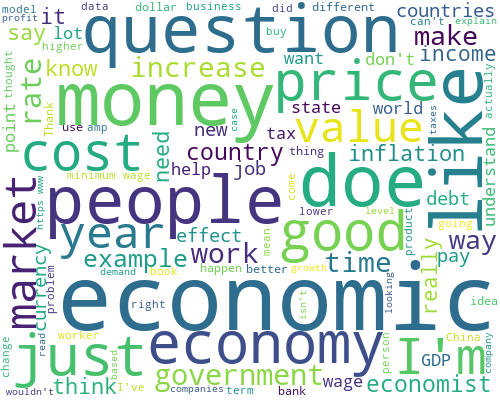

In [27]:
wc = wordcloud.WordCloud(width=500, height=400, max_words=100, stopwords=ENGLISH_STOP_WORDS, background_color='white')

text = df['all_text'].str.cat()

wc.generate_from_text(text)
wc.to_file("./images/all_no_stops-wordcloud.png")
wc.to_image()

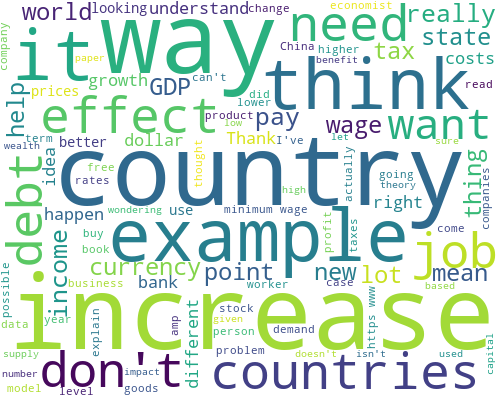

In [28]:
wc = wordcloud.WordCloud(width=500, height=400, max_words=100, stopwords=stops, background_color='white')

text = df['all_text'].str.cat()

wc.generate_from_text(text)
wc.to_file("./images/all_stops-wordcloud.png")
wc.to_image()

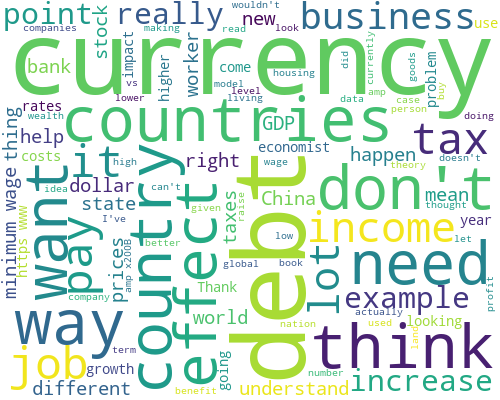

In [29]:
wc = wordcloud.WordCloud(width=500, height=400, max_words=100, stopwords=stops, background_color='white')

text = df.loc[df['subreddit_askeconomists']==1, 'all_text'].str.cat()

wc.generate_from_text(text)
wc.to_file("./images/askeconomists-wordcloud.png")
wc.to_image()

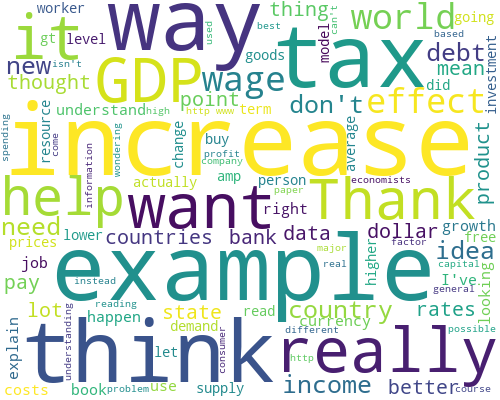

In [30]:
wc = wordcloud.WordCloud(width=500, height=400, max_words=100, stopwords=stops, background_color='white')

text = df.loc[df['subreddit_askeconomists']==0, 'all_text'].str.cat()

wc.generate_from_text(text)
wc.to_file("./images/askeconomics-wordcloud.png")
wc.to_image()

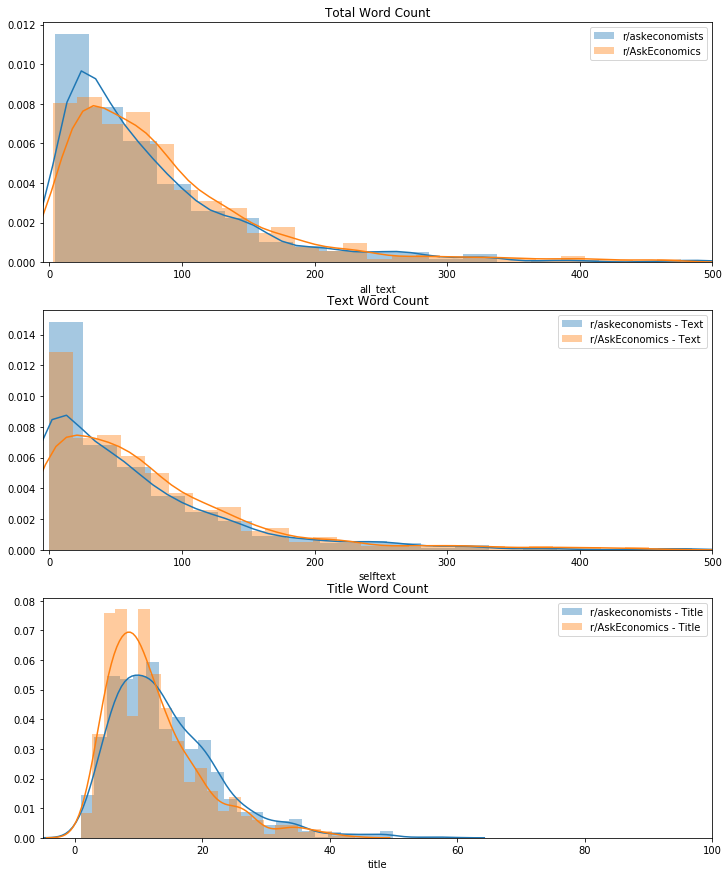

In [31]:
def get_len(subreddit, column='all_text'):
    return df.loc[df['subreddit_askeconomists'] == subreddit, column].map(lambda x: len(x.split()))
len_ists = get_len(1)
len_ics = get_len(0)
len_title_ists = get_len(1, column='title')
len_title_ics = get_len(0, column='title')
len_stext_ists = get_len(1, column='selftext')
len_stext_ics = get_len(0, column='selftext')

fig , (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12,15))
sns.distplot(len_ists, label = 'r/askeconomists', ax=ax1)
sns.distplot(len_ics, label = 'r/AskEconomics', ax=ax1)
ax1.set_xbound(-5,500)
ax1.set_title("Total Word Count")
ax1.legend();

sns.distplot(len_stext_ists, label = 'r/askeconomists - Text', ax=ax2)
sns.distplot(len_stext_ics, label = 'r/AskEconomics - Text', ax=ax2)
ax2.set_xbound(-5,500)
ax2.set_title("Text Word Count")
ax2.legend();

sns.distplot(len_title_ists, label = 'r/askeconomists - Title', ax=ax3)
sns.distplot(len_title_ics, label = 'r/AskEconomics - Title', ax=ax3)
ax3.set_xbound(-5,100)
ax3.set_title("Title Word Count")
ax3.legend();


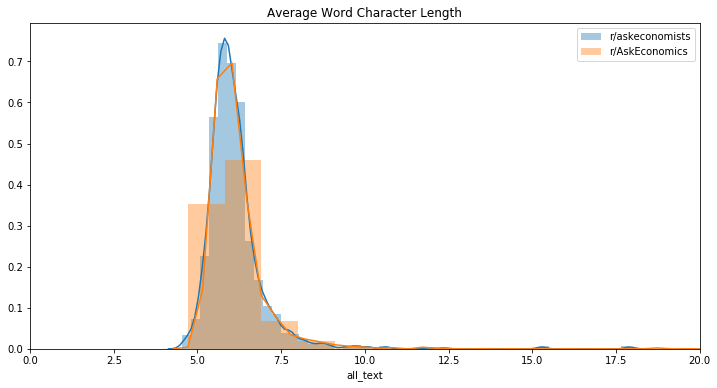

In [32]:
def get_avg_char_len(subreddit):
    return df.loc[df['subreddit_askeconomists'] == subreddit, 'all_text'].map(lambda x: len(x)/len(x.split()))
chlen_ists = get_avg_char_len(1)
chlen_ics = get_avg_char_len(0)
fig , ax = plt.subplots(figsize=(12,6))
sns.distplot(chlen_ists, label = 'r/askeconomists')
sns.distplot(chlen_ics, label = 'r/AskEconomics')
ax.set_xbound(0,20)
ax.set_title("Average Word Character Length")
ax.legend();

# Model the Data 

[Return to Table of Contents](#Contents:)

In [33]:
X = df['all_text']
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [34]:
pipe_cv = Pipeline([
    ('cv', CountVectorizer(max_df=.9)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter=1e6))
])

params_grid_cv = {
    'cv__max_features': [100, 500, 700],
    'cv__stop_words': [ENGLISH_STOP_WORDS, stops, None],
    'cv__ngram_range': [(1,2), (1,3)],
    'cv__min_df' : [10, 1]
}

gs_cv = GridSearchCV(pipe_cv, params_grid_cv, cv=5)
gs_cv.fit(X_train, y_train)
print(f'GridSearch on LogisticRegression - CV training data is {gs_cv.score(X_train, y_train)}.')
print(f'GridSearch on LogisticRegression - CV testing data is {gs_cv.score(X_test, y_test)}.')

GridSearch on LogisticRegression - CV training data is 0.869268897149938.
GridSearch on LogisticRegression - CV testing data is 0.5640074211502782.


In [35]:
pipe_tfv = Pipeline([
    ('tfv', TfidfVectorizer(max_df=.9)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter=1e6))
])

params_grid_tfv = {
    'tfv__max_features': [100, 500, 700],
    'tfv__stop_words': [ENGLISH_STOP_WORDS, stops, None],
    'tfv__ngram_range': [(1,2), (1,3)],
    'tfv__min_df' : [10, 1]
}

gs_tfv = GridSearchCV(pipe_tfv, params_grid_tfv, cv=5)
gs_tfv.fit(X_train, y_train)
print(f'GridSearch on LogisticRegression - TFIDV training data is {gs_tfv.score(X_train, y_train)}.')
print(f'GridSearch on LogisticRegression - TFIDV testing data is {gs_tfv.score(X_test, y_test)}.')

GridSearch on LogisticRegression - TFIDV training data is 0.7719950433705081.
GridSearch on LogisticRegression - TFIDV testing data is 0.5807050092764379.


In [36]:
pipe_cv_mnb = Pipeline([
    ('cv', CountVectorizer(max_df=.9)),
    ('mnb', MultinomialNB())
])

gs_cv_mnb = GridSearchCV(pipe_cv_mnb, params_grid_cv, cv=5)
gs_cv_mnb.fit(X_train, y_train)
print(f'GridSearch on MultinomialNB - CV training data is {gs_cv_mnb.score(X_train, y_train)}.')
print(f'GridSearch on MultinomialNB - CV testing data is {gs_cv_mnb.score(X_test, y_test)}.')

GridSearch on MultinomialNB - CV training data is 0.6369268897149938.
GridSearch on MultinomialNB - CV testing data is 0.5454545454545454.


In [37]:
# pipe_tfv_gb = Pipeline([
#     ('tfv', TfidfVectorizer(max_df=.9)),
#     ('gb', GaussianNB())
# ])

# gs_tfv_gb = GridSearchCV(pipe_tfv_gb, params_grid_tfv, cv=5)
# gs_tfv_gb.fit(X_train.todense(), y_train)
# print(f'GridSearch on GaussianNB - TFIDV training data is {gs_tfv_gb.score(X_train.todense(), y_train)}.')
# print(f'GridSearch on GaussianNB - TFIDV testing data is {gs_tfv_gb.score(X_test.todense(), y_test)}.')

## Evaluate the Models

[Return to Table of Contents](#Contents:)

In [38]:
# gs_cv.best_params_

In [39]:
cv_lr_estimator = gs_cv.best_estimator_
cv_lr_estimator

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=700, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000000.0,
                                    multi_class='warn', n_jobs=None,
                       

,LogR_Coef
000,-0.289662
10,0.450959
100,0.511746
15,-0.141781
20,-0.855318
...,...
year,-0.120151
years,0.484223
you,0.200787
your,-0.264669


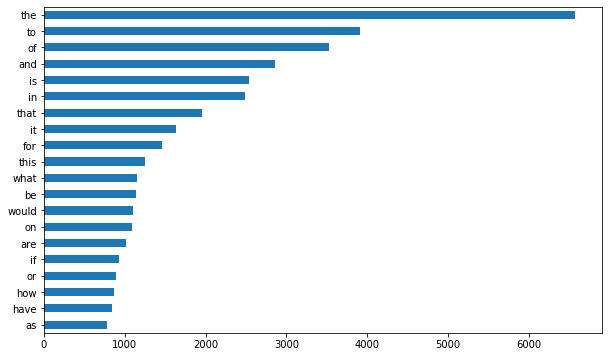

In [40]:
cv_estimator = gs_cv.best_estimator_[0]

df_words_cv = pd.DataFrame(gs_cv.best_estimator_[1].coef_,
                        columns=cv_estimator.get_feature_names(),
                        index=['LogR_Coef']).T


df_X_cv = pd.DataFrame(cv_estimator.fit_transform(X_train).todense(),
              columns=cv_estimator.get_feature_names())

fig , ax = plt.subplots(figsize=(10,6))

df_X_cv.sum().sort_values().tail(20).plot.barh();

df_words_cv

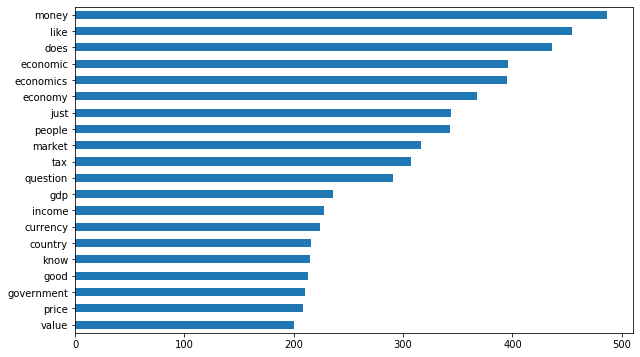

In [41]:
cv = CountVectorizer(max_df=.9,
                     stop_words=ENGLISH_STOP_WORDS,
                    max_features= 700,
                    ngram_range= (1,3))

df_X_cv_nostop = pd.DataFrame(cv.fit_transform(X_train).todense(),
              columns=cv.get_feature_names())

fig , ax = plt.subplots(figsize=(10,6))

df_X_cv_nostop.sum().sort_values().tail(20).plot.barh();

In [42]:
# gs_tfv.best_params_

,LogR_Coef
000,-0.637263
10,0.456209
100,0.310839
1000,-0.270862
15,-0.411707
...,...
x200b,0.943159
year,-0.459338
years,0.365856
yield,-0.166736


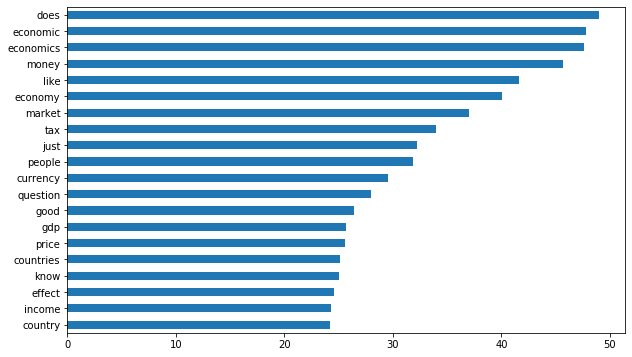

In [43]:
tfv_estimator = gs_tfv.best_estimator_[0]

df_X_tfv = pd.DataFrame(tfv_estimator.fit_transform(X_train).todense(),
              columns=tfv_estimator.get_feature_names())

fig , ax = plt.subplots(figsize=(10,6))

df_X_tfv.sum().sort_values().tail(20).plot.barh();

df_words_tfv = pd.DataFrame(gs_tfv.best_estimator_[1].coef_,
                        columns=tfv_estimator.get_feature_names(), index=['LogR_Coef']).T

df_words_tfv

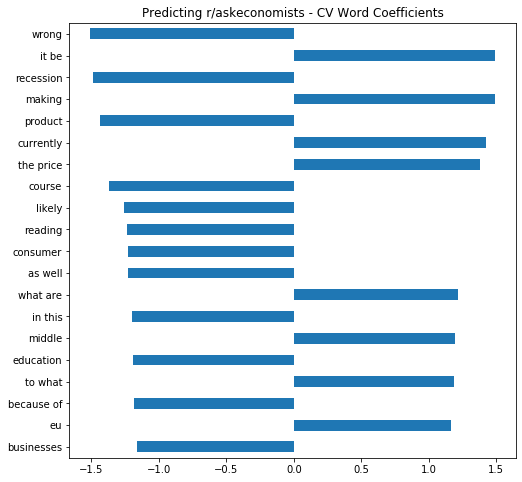

In [44]:
fig , ax = plt.subplots(figsize=(8,8))
coef_df = pd.DataFrame(gs_cv.best_estimator_[1].coef_,
                       columns=cv_estimator.get_feature_names()).T
coef_df['ABS'] = coef_df[0].abs()
ax.set_title("Predicting r/askeconomists - CV Word Coefficients");
coef_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax);
plt.savefig("./images/CV-Word-Coefficients_barh.png")

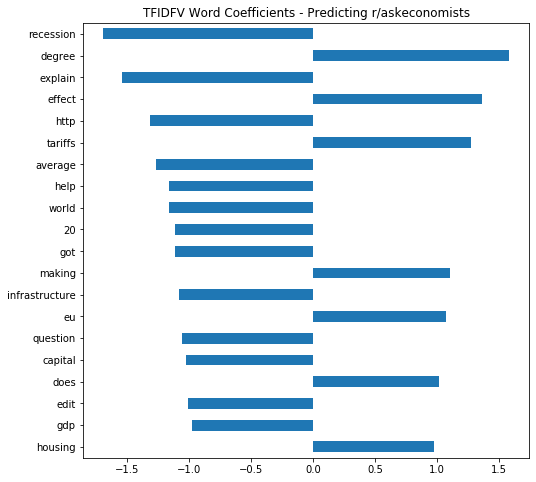

In [45]:
fig , ax = plt.subplots(figsize=(8,8))
coef_tf_df = pd.DataFrame(gs_tfv.best_estimator_[1].coef_,
                       columns=tfv_estimator.get_feature_names()).T
coef_tf_df['ABS'] = coef_tf_df[0].abs()
coef_tf_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax)
ax.set_title("TFIDFV Word Coefficients - Predicting r/askeconomists");
plt.savefig("./images/TFIDFV-Word-Coefficients_barh.png")

In [46]:
y.value_counts()

1    1226
0     927
Name: subreddit_askeconomists, dtype: int64

In [47]:
preds_cv = gs_cv.predict(X_test)
print("GridSearch LogR - CV predictions")
conf_cv = pd.DataFrame(confusion_matrix(y_test, preds_cv),columns=['Predicted r/askeconomists', 'Predicted r/AskEconomics'],
             index=['Actual r/askeconomists', 'Predicted r/AskEconomics'])
print(conf_cv)
print("Accuracy score:",accuracy_score(y_test, preds_cv))
print()

preds_tfv = gs_tfv.predict(X_test)
print("GridSearch LogR - TFIDV predictions")
conf_tfv = pd.DataFrame(confusion_matrix(y_test, preds_tfv),columns=['Predicted r/askeconomists', 'Predicted r/AskEconomics'],
             index=['Actual r/askeconomists', 'Predicted r/AskEconomics'])
print(conf_tfv)
print("Accuracy score:",accuracy_score(y_test, preds_tfv))
print()

preds_cv_mnb = gs_cv_mnb.predict(X_test)
print("GridSearch MultinomialNB - CV predictions")
conf_cv_mnb = pd.DataFrame(confusion_matrix(y_test, preds_cv_mnb),columns=['Predicted r/askeconomists', 'Predicted r/AskEconomics'],
             index=['Actual r/askeconomists', 'Predicted r/AskEconomics'])
print(conf_cv_mnb)
print("Accuracy score:",accuracy_score(y_test, preds_cv_mnb))

# predicting if subreddit == askeconomists (as opposed to AskEconomics)

tn_cv, fp_cv, fn_cv, tp_cv  = confusion_matrix(y_test, preds_cv).ravel()

tn_tfv, fp_tfv, fn_tfv, tp_tfv  = confusion_matrix(y_test, preds_tfv).ravel()

tn_cv_mnb, fp_cv_mnb, fn_cv_mnb, tp_cv_mnb  = confusion_matrix(y_test, preds_cv_mnb).ravel()

GridSearch LogR - CV predictions
                          Predicted r/askeconomists  Predicted r/AskEconomics
Actual r/askeconomists                           88                       144
Predicted r/AskEconomics                         91                       216
Accuracy score: 0.5640074211502782

GridSearch LogR - TFIDV predictions
                          Predicted r/askeconomists  Predicted r/AskEconomics
Actual r/askeconomists                           83                       149
Predicted r/AskEconomics                         77                       230
Accuracy score: 0.5807050092764379

GridSearch MultinomialNB - CV predictions
                          Predicted r/askeconomists  Predicted r/AskEconomics
Actual r/askeconomists                           84                       148
Predicted r/AskEconomics                         97                       210
Accuracy score: 0.5454545454545454


In [48]:
conf_cv

,Predicted r/askeconomists,Predicted r/AskEconomics
Actual r/askeconomists,88,144
Predicted r/AskEconomics,91,216


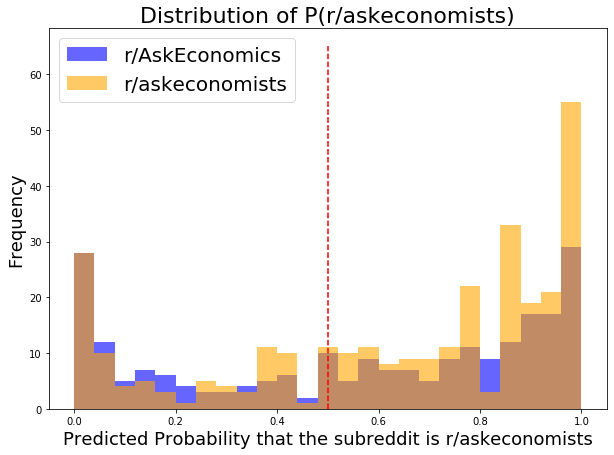

In [49]:
pred_proba = [i[1] for i in cv_lr_estimator.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

plt.figure(figsize = (10,7))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='r/AskEconomics')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='r/askeconomists')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

plt.title('Distribution of P(r/askeconomists)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that the subreddit is r/askeconomists', fontsize=18)

plt.legend(fontsize=20);

plt.savefig("./images/pred_proba-comparison-hist.png")

In [50]:
wrong_preds_ls = []
accurate_preds_ls = []
for words, prediction, label in zip(X_test, preds_cv, y_test):
    if prediction != label:
        wrong_preds = {}
        wrong_preds["text"]= words
        wrong_preds["prediction"] = prediction
        wrong_preds["actual"] = label
        wrong_preds_ls.append(wrong_preds.copy())
    else:
        accurate_preds = {}
        accurate_preds["text"]= words
        accurate_preds["prediction"] = prediction
        accurate_preds["actual"] = label
        accurate_preds_ls.append(accurate_preds.copy())
        
wrong_preds_df = pd.DataFrame(wrong_preds_ls)
accurate_preds_df = pd.DataFrame(accurate_preds_ls)

# ^ zip adapted from https://stackoverflow.com/questions/45176469/can-i-get-a-list-of-wrong-predictions-in-svm-score-function-in-scikit-learn

In [51]:
wrong_preds_df.head()

,text,prediction,actual
0,"Energy consumption taxes, tax incidence and el...",1,0
1,"Why QE? Why not ""drop money from a helicopter""...",1,0
2,"Where can I find the cost structure of Ford, C...",1,0
3,Is Greece being forced out of the Euro? I'm a...,1,0
4,Where can I look up the cities/zip codes with ...,1,0


In [52]:
accurate_preds_df.head()

,text,prediction,actual
0,how to find criticism of economics papers or p...,1,1
1,"Optimization of Households' utility in "" Rule-...",0,0
2,If we could track all the new money created in...,1,1
3,US GDP compared to actual floating dollars I ...,0,0
4,Chinese yuan appreciation Okay so I'm just wo...,0,0


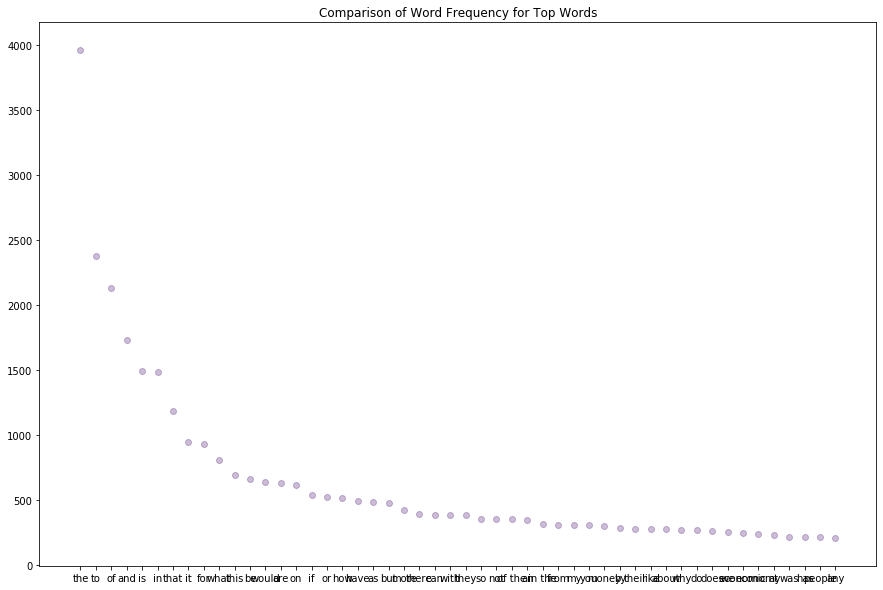

In [53]:
# freq_words = list(df_X_cv.sum().sort_values(ascending=False).head(30).index)

df_ists = df[df['subreddit_askeconomists']==1].copy()
df_ics = df[df['subreddit_askeconomists']==0].copy()

#top_wordcnt_ists = [df_ists.sum() for x in df_X_cv.sort_values(ascending=False).head(50)]
#top_words_ists = df_ists.sum().sort_values(ascending=False).head(50).index
#top_wordcnt_ics = df_ics.sum().sort_values(ascending=False).head(50)
#top_words_ics = df_ics.sum().sort_values(ascending=False).head(50).index
df_ists_cv = pd.DataFrame(cv_estimator.transform(df_ists['all_text']).todense(),
                 columns=cv_estimator.get_feature_names()) 
df_ics_cv = pd.DataFrame(cv_estimator.transform(df_ics['all_text']).todense(),
                 columns=cv_estimator.get_feature_names())  
top_wordcnt_ists = [x for x in df_ics_cv.sum().sort_values(ascending=False).head(50)]
top_words_ists = [x for x in df_ists_cv.sum().sort_values(ascending=False).head(50).index]
top_wordcnt_ics = [x for x in df_ics_cv.sum().sort_values(ascending=False).head(50)]
top_words_ics = [x for x in df_ists_cv.sum().sort_values(ascending=False).head(50).index]


fig, ax1 = plt.subplots(figsize=(15,10))

plt.scatter(top_words_ics, top_wordcnt_ics, c='orange', alpha=.2)
plt.scatter(top_words_ists, top_wordcnt_ists, c='blue', alpha=.2)

# plt.annotate(df_X_cv.sum().index, (z[i], y[i]))
# ^ annotate adapted from https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

# df_ists.loc[freq_words].sum().plot.barh(ax=ax1, color='green');
# df_ics.loc[freq_words].sum().plot.barh(ax=ax2, color='black');

ax1.set_title('Comparison of Word Frequency for Top Words');

# column comparison ...
# scatterplot of frequency ...

In [54]:
# #df_ists_cv = pd.DataFrame(cv_estimator.fit_transform(df_ists['all_text']).todense(),
# #                 columns=cv_estimator.get_feature_names()) 
# pd.DataFrame(cv_estimator.fit_transform(df_ics['all_text']).todense(),
#                  columns=cv_estimator.get_feature_names()) 


In [55]:
#[x for x in df_ics_cv.sum().sort_values(ascending=False).head(50)]